<p><img alt="Colaboratory logo" height="45px" src="https://www.quantreo.com/wp-content/uploads/2021/10/Original-on-Transparent.png" align="left" hspace="10px" vspace="0px"></p>

# Vectorized BackTesting
Backtesting is an essential part of trading. Indeed, it is important to understand the behavior of your strategy in the past to be able to consider those of future.
### Content

* Sortino Beta Alpha
* Drawdown 
* Create function BackTest to evaluate the strategy in the later sections

</br>

💰Join our community: https://discord.gg/wXjNPAc5BH

📚Read our book: https://www.amazon.com/gp/product/B09HG18CYL 

🖥️Quantreo's YouTube channel: https://www.youtube.com/channel/UCp7jckfiEglNf_Gj62VR0pw

### Environnement

In [ ]:
!pip install yfinance    

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from matplotlib import cycler

colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")
plt.rc('figure', facecolor='#313233')

# Section 1: Sortino Beta Alpha

###### Sortino
The sortino ratio is a statistic similar to the sharpe ratio with the same interpretation. However, the calculation is slightly different. Indeed, in the sortino ratio we only take into account the volatility of the negative gains because that is what we fear and not the bullish gains that make us earn money. <br>
<p align="center">
$Sortino = \frac{\mu }{\sigma_{down}}$
<p> <br>

*   SortinoRatio < 0 : Not profitable investissement because you gains is negative.
*   SortinoRatio < 1 : Profitable investissement but the risk of the investissement is higher than the returns.
*   SortinoRatio > 1: Very good investissement because the risk is lower than the returns.


In [ ]:
# Prepare the datas 
f = yf.download("GOOG", end="2021-01-01")
return_serie = f["Adj Close"].pct_change(1).dropna()
return_serie.name = "return"

# Compute the sortino
mean = np.mean(return_serie) #252
vol = np.std(return_serie[return_serie<0]) #sqrt(252)
sortino = np.sqrt(252) * mean/vol

print(f"Sortino: {'%.3f' % sortino}")

[*********************100%***********************]  1 of 1 completed
Sortino: 1.232


###### Beta
The beta is a statistic that indicates the relationship between the variations of our portfolio and those of the market which is represented by an index (for example SP500). <br>

<p align="center">
$Beta = \frac{Cov(r_{M},r_{PF}) }{Var(r_{M})}$
<p> <br>



*   abs(Beta) < 1: It is good because it means that your portfolio have a less variation than the index. (If beta=0.9 this means that if the index varies of 1 the portfolio varies by 0.9)
*   abs(Beta) > 1: It is not a good thing because it means that your portfolio have a higher variation than the index. (If beta=1.1 this means that if the index varies of 1 the portfolio varies by 1.1)

**abs(-x) = x = abs(x) (abs gives only the value of the variable not the sign)*


In [ ]:
# We need compute the covariance between the marlet and the portfolio 
sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
sp500.name = "SP500"

# We concate them to do the covariances
val = pd.concat((return_serie, sp500), axis=1).dropna()

# We compute beta 
cov_var_mat = np.cov(val.values, rowvar=False)
cov = cov_var_mat[0][1]
var = cov_var_mat[1][1]

beta = cov/var

print(f"Beta: {'%.3f' % beta}")

[*********************100%***********************]  1 of 1 completed
Beta: 0.965


###### **Alpha**
Alpha is a statistic that indicates whether the portfolio outperforms the market in terms of risk return. <br>

<p align="center">
$Alpha = r_{PF} - \beta*(r_{PF} - r_{f}) - r_{f}$
<p> <br>


*   alpha > 0: The portfolio outperforms the market in terms of risk return
*   alpha < 0: The portfolio underperforms the market in terms of risk return


In [ ]:
# We compute alpha 
alpha = (252 * mean * (1-beta))*100
print(f"Alpha: {'%.1f' % alpha}")

Alpha: 0.9


# Section 2: Drawdown

The drawdown is a measure of the risk of the strategy. An interesting statistic to know the performance of the algorithm is the maximum drawdown. Indeed, it represents the maximum loss of a strategy over a period of time which allows you to understand if the strategy is risky and thus choose it according to your level of risk aversion.

In [ ]:
def drawdown_function(serie):

  # We compute Cumsum of the returns
  cum = serie.dropna().cumsum() + 1

  # We compute max of the cumsum on the period (accumulate max) # (1,3,5,3,1) --> (1,3,5,5,5)
  running_max = np.maximum.accumulate(cum)

  # We compute drawdown
  drawdown = cum/running_max - 1
  return drawdown

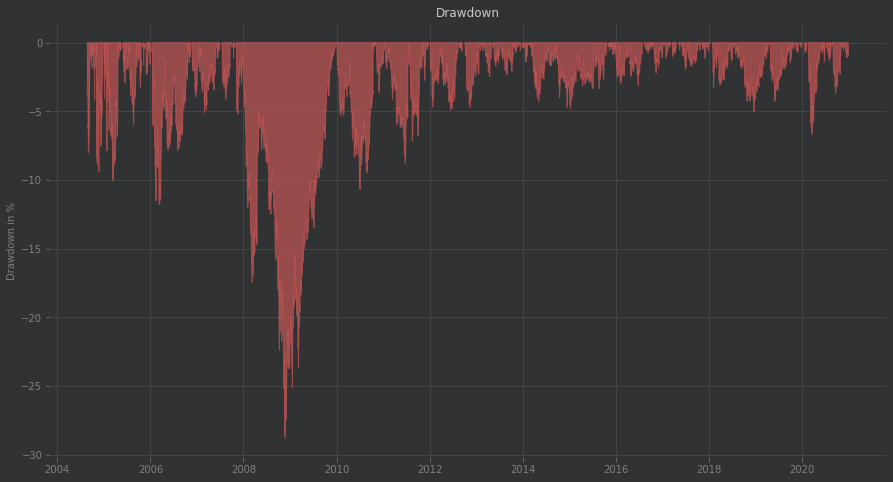

In [ ]:
# We compute drawdown
drawdown = drawdown_function(return_serie)

# Adapt figure size
plt.figure(figsize=(15,8))

# Plot the drawdown
plt.fill_between(drawdown.index, drawdown*100, 0,
                 drawdown, color="#CE5757", alpha=0.65)

# Put a title
plt.title("Drawdown")

# Put y label
plt.ylabel("Drawdown in %")

plt.show()


In [ ]:
# Computation Max drawdown
max_drawdown = -np.min(drawdown)*100
print(f"Max drawdown: {'%.1f' % max_drawdown} %")

Max drawdown: 28.8 %


# Section 3: Create function BackTest to evaluate the strategy in the later sections

In [ ]:
def BackTest(serie, annualiazed_scalar=252):

  # Import the benchmark
  sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
  
  # Change the name
  sp500.name = "SP500"

  # Concat the returns and the sp500
  val = pd.concat((serie,sp500), axis=1).dropna()
  # Compute the drawdown
  drawdown = drawdown_function(serie)*100
  
  # Compute max drawdown
  max_drawdown = -np.min(drawdown)




  # Put a subplots
  fig, (cum, dra) = plt.subplots(1,2, figsize=(20,6))
  
  # Put a Suptitle
  fig.suptitle("Backtesting", size=20)

  # Returns cumsum chart
  cum.plot(serie.cumsum()*100, color="#39B3C7")

  # SP500 cumsum chart
  cum.plot(val["SP500"].cumsum()*100, color="#B85A0F")

  # Put a legend
  cum.legend(["Portfolio", "SP500"])
  
  # Set individual title
  cum.set_title("Cumulative Return", size=13)

  cum.set_ylabel("Cumulative Return %", size=11)

  # Put the drawdown
  dra.fill_between(drawdown.index,0,drawdown, color="#C73954", alpha=0.65)

  # Set individual title
  dra.set_title("Drawdown", size=13)

  dra.set_ylabel("drawdown in %", size=11)

  # Plot the graph
  plt.show()


  # Compute the sortino
  sortino = np.sqrt(annualiazed_scalar) * serie.mean()/serie.loc[serie<0].std()

  # Compute the beta
  beta = np.cov(val[["return", "SP500"]].values,rowvar=False)[0][1] / np.var(val["SP500"].values)

  # Compute the alpha
  alpha = annualiazed_scalar * (serie.mean() - beta*serie.mean())

  # Print the statistics
  print(f"Sortino: {np.round(sortino,3)}")
  print(f"Beta: {np.round(beta,3)}")
  print(f"Alpha: {np.round(alpha*100,3)} %")
  print(f"MaxDrawdown: {np.round(max_drawdown,3)} %")

[*********************100%***********************]  1 of 1 completed


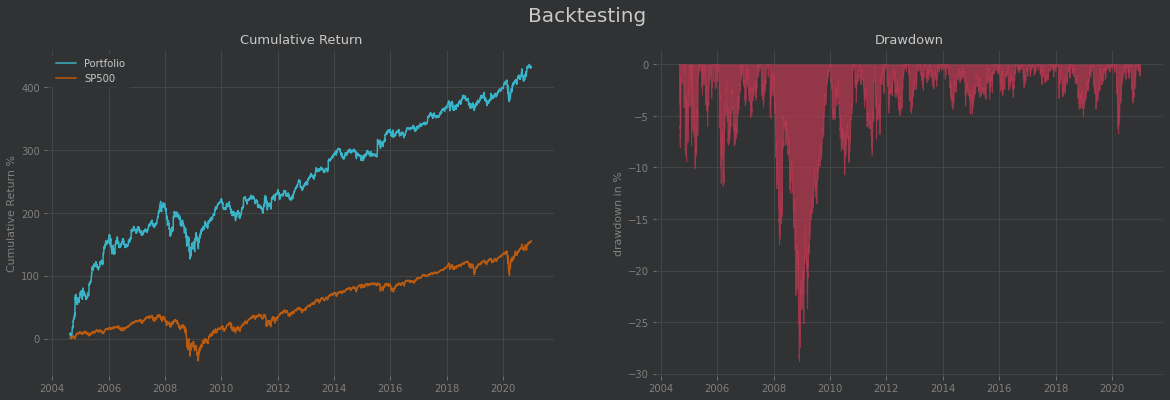

Sortino: 0.269
Beta: 0.965
Alpha: 0.044 %
MaxDrawdown: 28.78 %


In [ ]:
BackTest(return_serie, 252)

##### APPLICATION

In [ ]:
!pip install ta

  Created wheel for ta: filename=ta-0.7.0-py3-none-any.whl size=28718 sha256=c6b535db31b327f17ab80a9c72b6d80a47597276163473356e8c7080c9f74682
  Stored in directory: /root/.cache/pip/wheels/5e/74/e0/72395003bd1d3c8f3f5860c2d180ff15699e47a2733d8ebd38
Successfully built ta


In [ ]:
import ta
def lin_reg_trading(symbol):

  def feature_engineering(df):
    """ Create new variables"""
    
    # We copy the dataframe to avoid interferences in the data
    df_copy = df.dropna().copy()
    
    # Create the returns
    df_copy["returns"] = df_copy["close"].pct_change(1)

    # Create the SMAs
    df_copy["SMA 15"] = df_copy[["close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["close"]].rolling(60).mean().shift(1)
    
    # Create the volatilities
    df_copy["MSD 10"] = df_copy[["returns"]].rolling(10).std().shift(1)
    df_copy["MSD 30"] = df_copy[["returns"]].rolling(30).std().shift(1)
    
    # Create the Rsi
    RSI = ta.momentum.RSIIndicator(df_copy["close"], window= 14, fillna = False)
    df_copy["rsi"] = RSI.rsi()
    
    return df_copy.dropna()
  

  # Import the data
  df = yf.download(symbol)

  # Take adjusted close
  df = df[["Adj Close"]]

  # Rename the column
  df.columns = ["close"]

  dfc = feature_engineering(df)

  # Percentage train set
  split = int(0.80*len(dfc))

  # Train set creation
  X_train = dfc[['SMA 15', 'SMA 60', 'MSD 10', 'MSD 30', 'rsi']].iloc[:split]
  y_train = dfc[["returns"]].iloc[:split]


  # Test set creation
  X_test = dfc[['SMA 15', 'SMA 60', 'MSD 10', 'MSD 30', 'rsi']].iloc[split:]
  y_test = dfc[["returns"]].iloc[split:]

  # Import the class
  from sklearn.linear_model import LinearRegression

  # Initialize the class
  reg = LinearRegression()

  # Fit the model
  reg.fit(X_train, y_train)

  # Create predictions for the whole dataset
  X = np.concatenate((X_train, X_test), axis=0)

  dfc["prediction"] = reg.predict(X)

  # Compute the position
  dfc["position"] = np.sign(dfc["prediction"])

  # Compute the returns
  dfc["strategy"] = dfc["returns"] * dfc["position"].shift(1)

  dfc["return"] = dfc["strategy"]

  BackTest(dfc["return"].iloc[split:])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


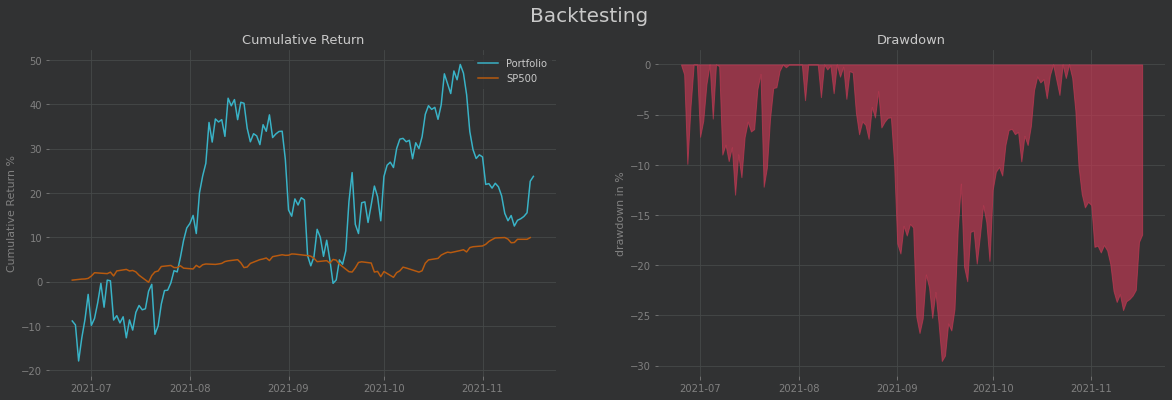

Sortino: 0.841
Beta: -1.143
Alpha: 87.801 %
MaxDrawdown: 29.531 %


In [ ]:
lin_reg_trading("ETH-EUR")